### Импорт пакетов

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
path = '../data/'

### Зависимость мощности излучения от мощности накачки
Мы это прямо померили

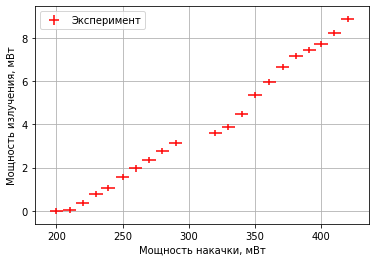

In [16]:
# считывание данных
data1 = np.genfromtxt('%sdata1.txt'%path)

p_n = data1[:, 0]  # накачка
p_iz = data1[:, 1]  # излучение

p_iz -= p_iz[-1]  # учёт фоновой засветки

# погрешности, выбраны из соображения, что там всё "дышало"
p_n_err = np.ones(len(p_iz)) * 5  # мВт
p_iz_err = np.ones(len(p_iz)) * 14e-2  # мВт, взял за погрешность величину фоновой засветки

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.errorbar(p_n, p_iz, xerr=p_n_err, yerr=p_iz_err, label='Эксперимент', ls='', color='red', ms=4)

ax.set_ylabel('Мощность излучения, мВт')
ax.set_xlabel('Мощность накачки, мВт')

ax.grid()
ax.legend()

fig.savefig('../figures/p_iz_vs_p_nak.png', dpi=300, bbox_inches='tight')

Отсюда видно, что мощность излучения уходит в нуль при уменьшении мощности накачки. Мощность излучения совсем зануляется при $$P_{нак}<210\,\text{мВт}.$$ Порог находится где-то между $200\,\text{мВт}$ и $210\,\text{мВт}$. Значит, $P_{пор} = 205\pm5\,\text{мВт}.$

### Погрешность параметра накачки

Параметр накачки по определению $A = P_{нак} / P_{пор}$. Погрешность будет 
$$
\Delta A = \dfrac{\Delta P_{нак}}{P_{пор}} + P_{нак} \dfrac{\Delta P_{пор}}{P_{пор}^2} = \dfrac{3}{205} + P_{нак} \dfrac{5}{205^2}.
$$
Погрешность параметра накачки хоть и слабо, но зависит от мощности накачки.

### Релаксационная частота
Релаксационная частота $\Omega = 2\pi \nu T_1$, мы меряем $\nu = f_{rel}$

In [36]:
# загружаем данные
data2 = np.genfromtxt('%sdata2.txt'%path)

p_n_2 = data2[:, 0]  # мощность накачки
f_rel = data2[:, 1]  # частота релаксационный колебаний

# погрешности
p_n_2_err = np.ones(len(p_n_2)) * p_n_err[0]  # мВт
f_rel_err = np.ones(len(p_n_2)) * 10  # кГц

A_2 = p_n_2 / 205  # параметр накачки
A_2_err = p_n_2_err / 205 + p_n_2 * 5 / 205**2

T_1 = 0.23  # мс
Omega = 2 * np.pi * f_rel * T_1

Omega_err = 2 * np.pi * f_rel_err * T_1

### Зависимость параметра $G$ от параметра накачки

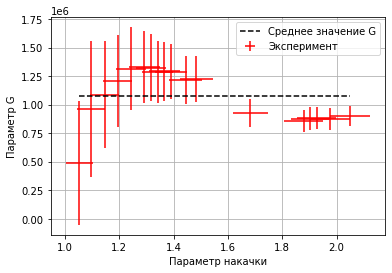

In [15]:
G = Omega**2 / (A_2 - 1)

G_err = 2 * Omega * Omega_err / (A_2 - 1) + Omega**2 * A_2_err / (A_2 - 1)**2

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.errorbar(A_2, G, xerr=A_2_err, yerr=G_err, label='Эксперимент', ls='', color='red', ms=4)
ax.plot(A_2, np.ones(len(A_2))*G.mean(), color='black', linestyle='--', label='Среднее значение G')

#p1 = np.poly1d(np.polyfit(A, p_iz, 1))
#ax.plot(A, p1(A), color='black', linestyle='-', label='Лин. аппроксим.', lw=1)

ax.set_ylabel('Параметр G')
ax.set_xlabel('Параметр накачки')

ax.grid()
ax.legend()

fig.savefig('../figures/g_vs_a.png', dpi=300, bbox_inches='tight')

Погрешность параметра G сильно разница, давайте будет писать среднее G с точностью до второго знака после запятой 

In [19]:
print(f'G = {G.mean():.3} +- {np.sqrt(G.std()**2 + G_err.mean()**2):.2}')

G = 1.07e+06 +- 3.5e+05


### Зависимость мощности излучения от параметра накачки

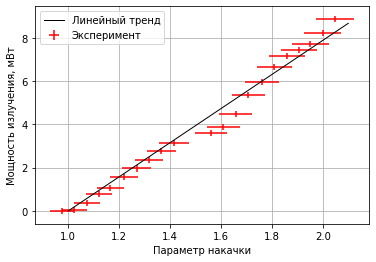

In [55]:
from scipy.optimize import curve_fit

def lin(x, p):
    return p * (x - 1)

A = p_n / 205  # параметр накачки
A_err = p_n_err / 205 + p_n * 5 / 205**2

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.errorbar(A, p_iz, xerr=A_err, yerr=p_iz_err, label='Эксперимент',
            ls='', color='red', ms=4)

popt, pcov = curve_fit(lin, A, p_iz)

ax.plot(np.linspace(1,2.1,1000), lin(np.linspace(1,2.1,1000), popt),
        color='black', linestyle='-', label='Линейный тренд', lw=1)

ax.set_ylabel('Мощность излучения, мВт')
ax.set_xlabel('Параметр накачки')

ax.grid()
ax.legend()

fig.savefig('../figures/p_iz_vs_A.png', dpi=300, bbox_inches='tight')

### Зависимость частоты релаксационных колебаний от параметра накачки

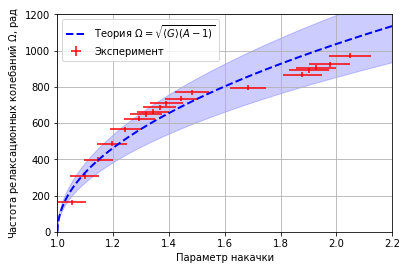

In [53]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.errorbar(A_2, Omega, xerr=A_2_err, yerr=Omega_err, label='Эксперимент',
            ls='', color='red', ms=4)
ax.plot(np.linspace(1,2.5,1000), np.sqrt(G.mean()*(np.linspace(1,2.5,1000)-1)),
        label=r'Теория $\Omega=\sqrt{\langle G \rangle (A-1)}$', color='blue', lw=2, ls='--')
ax.fill_between(np.linspace(1,2.5,1000), np.sqrt((G.mean()-0.35e6)*(np.linspace(1,2.5,1000)-1)),
        np.sqrt((G.mean()+0.35e6)*(np.linspace(1,2.5,1000)-1)), alpha=0.2, color='blue')

#p1 = np.poly1d(np.polyfit(A, p_iz, 1))
#ax.plot(A, p1(A), color='black', linestyle='-', label='Лин. аппроксим.', lw=1)

ax.set_ylabel(r'Частота релаксационных колебаний $\Omega$, рад')
ax.set_xlabel('Параметр накачки')

ax.set_xlim([1,2.2])
ax.set_ylim([0, 1200])

ax.grid()
ax.legend()

fig.savefig('../figures/Omega_vs_A.png', dpi=300, bbox_inches='tight')

### Оценка полосы резонатора лазера $\delta f_{эксп}$

Средняя $G=(1.07 \pm 0.35)\times10^{6}$, отсюда находим $\delta f_{эксп} = \frac{1}{2\pi T_\text{с}}$ следующим образом:
$$
G = \frac{T_1}{T_\text{с}}\; \Longrightarrow \; \delta f_{эксп} = \frac{G}{2\pi T_1} = \frac{1.07\times10^6}{2 \pi\, 0.23\times10^{-3}\,\text{с}} = 7.44\times10^8\, \text{Гц}.
$$
С учетом погрешности получаем $\delta f_{эксп} = (7.44\pm2.43)\times10^8\,\text{Гц}$.

In [56]:
print(f'{G.mean() / (2 * np.pi * 0.23e-3):.3} +- {np.sqrt(G.std()**2 + G_err.mean()**2) / (2 * np.pi * 0.23e-3):.3}')

7.44e+08 +- 2.43e+08


### Сравнение экспериментальной полосы с теоретическим значением

Теоретическое значение $$\delta f_\text{теор} = -\frac{c \ln{\sqrt{R_1 R_2}}}{2\pi L} \approx - 3\times10^8 \ln{\sqrt{1\times 0.98}}\; /\;(6.28 \times 0.01) = 4.83\times10^8\,\text{Гц}$$. Взяли $L=1\,\text{мм}$.

In [65]:
print(f'{-3e8 * np.log(np.sqrt(1 * 0.98)) / (6.28 * 0.001):.3}')

4.83e+08
